# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '14'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"
fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 1716204)
Dimensions without coordinates: cell
Data variables:
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    n_ice                          (cell) float32 ...
    z_ice                          (cell) float32 ...
    q_snow                         (cell) float32 ...
    n_snow                         (cell) float32 ...
    z_snow                         (cell) float32 ...
    q_rimedice                     (cell) float32 ...
    n_rimedice                     (cell) float32 ...
    z_rimedice                     (cell) float32 ...
    rime_rimedice                  (cell) float32 ...
    rvol_rimedice                  (cell) float32 ...
    liq_r

# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    num  = xr.open_dataset(fname).n_rimedsnow.values
    rime = xr.open_dataset(fname).rime_rimedsnow.values
    rvol = xr.open_dataset(fname).rvol_rimedsnow.values
    liq  = xr.open_dataset(fname).liq_rimedsnow.values
    # read cloud and rain water data
    q_r  = xr.open_dataset(fname).q_rain.values
    n_r  = xr.open_dataset(fname).n_rain.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values        
    # process rates
    frze = xr.open_dataset(fname).frze_rimedsnow_rmass.values   # this is the liq->ice rate
    # rescale process rate with temperature 
    t_3  = 273.15
    frze = np.where(temp < t_3, frze/(t_3-temp), np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-18
    p_min = 1e-20
    # make sure that we have a barrier between physical values and the artificial zero value
    cwc = np.where(cwc>q_min*10,cwc,q_min)    
    q_r = np.where(q_r>q_min*10,q_r,q_min)    
    n_r = np.where(n_r>n_min*10,n_r,n_min)    
    # use liquid water fraction (here we exclude zero, because this is freezing)
    liq = np.where(q_s>q_min,liq/q_s,np.nan)  
    # transform everything in log space
    q_s  = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    num  = np.log(num, where=num>n_min, out=np.nan*q_s)
    rime = np.log(rime,where=rime>q_min, out=np.nan*q_s)
    rvol = np.log(rvol,where=rvol>q_min, out=np.nan*q_s)
    liq  = np.log(liq, where=liq>q_min, out=np.nan*liq)
    cwc  = np.log(cwc, where=cwc>p_min, out=np.nan*cwc)
    q_r  = np.log(q_r, where=q_r>p_min, out=np.nan*q_r)
    r_c  = np.log(r_c, where=r_c>p_min, out=np.nan*r_c)
    n_r  = np.log(n_r, where=n_r>p_min, out=np.nan*n_r)
    frze = np.log(frze,where=frze>p_min,out=np.nan*frze)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, num, rime, rvol, liq, cwc, r_c, q_r, n_r, frze, temp ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num', 'rime', 'rvol', 'liq', 'cwc', 'r_c', 'q_r', 'n_r', 'frze', 'temp' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s           num          rime          rvol           liq  \
count  19091.000000  19091.000000  19091.000000  19091.000000  19091.000000   
mean      -6.256368      5.468193     -6.697292    -12.702444     -4.514391   
std        2.003922      3.525103      2.124006      2.149042      3.019388   
min      -22.947466    -12.311334    -27.317013    -34.140301    -24.034239   
25%       -6.524880      4.723291     -7.012209    -13.045018     -6.170540   
50%       -5.859090      6.120520     -6.277915    -12.242712     -3.663319   
75%       -5.327757      7.577140     -5.626184    -11.598841     -2.244805   
max       -3.518044     11.085310     -3.621830     -9.060705     -0.000020   

                cwc           r_c           q_r           n_r          frze  \
count  19091.000000  19091.000000  19091.000000  19091.000000  19091.000000   
mean      -9.998993    -11.015247    -30.136412    -27.751768    -24.942360   
std        6.521653      0.482360      8.973348     13.613127      4.374687   
min      -34.538776    -12.203955    -34.538776    -34.538776    -43.065170   
25%       -9.586490    -11.337620    -34.538776    -34.538776    -27.618325   
50%       -8.351679    -10.961924    -34.538776    -34.538776    -24.874161   
75%       -7.274481    -10.617621    -34.538776    -34.538776    -22.102030   
max       -3.812178    -10.260426     -3.977586      8.803023    -11.434864   

               temp  
count  19091.000000  
mean     269.728088  
std        3.188603  
min      253.000000  
25%      267.899994  
50%      270.559998  
75%      272.350006  
max      273.140015

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       num      rime       rvol        liq        cwc  \
80   -6.080471  8.473637 -6.287889 -11.492300  -3.638443  -8.838777   
82   -6.064384  8.470059 -6.278230 -11.492329  -3.376351  -9.133379   
400  -6.272036  7.819676 -6.641935 -11.914188  -8.510327  -9.061920   
679  -7.291875  7.182458 -7.832691 -12.916155 -14.964878 -10.094648   
1041 -6.049348  8.600204 -6.308661 -11.644840  -7.800683  -8.314252   

            r_c        q_r        n_r       frze        temp  
80   -11.876107 -34.538776 -34.538776 -15.043899  272.980011  
82   -11.876107 -34.538776 -34.538776 -14.284544  273.100006  
400  -11.730050 -34.538776 -34.538776 -26.350163  269.769989  
679  -11.726924 -34.538776 -34.538776 -33.702072  267.899994  
1041 -11.435983 -34.538776 -34.538776 -25.714359  267.029999

In [11]:
dataset_train.describe()

q_s           num          rime          rvol           liq  \
count  13329.000000  13329.000000  13329.000000  13329.000000  13329.000000   
mean      -6.267855      5.463964     -6.707350    -12.712415     -4.530870   
std        2.036155      3.522020      2.153263      2.177540      3.033253   
min      -22.707214    -12.311334    -27.317013    -34.140301    -24.034239   
25%       -6.531657      4.717909     -7.012849    -13.055761     -6.196811   
50%       -5.865713      6.110487     -6.287254    -12.246366     -3.688855   
75%       -5.333518      7.581241     -5.631753    -11.599158     -2.248293   
max       -3.518060     10.957782     -3.621830     -9.060705     -0.000020   

                cwc           r_c           q_r           n_r          frze  \
count  13329.000000  13329.000000  13329.000000  13329.000000  13329.000000   
mean      -9.998124    -11.015905    -30.096041    -27.693420    -24.976082   
std        6.520080      0.483443      9.006006     13.660281      4.387121   
min      -34.538776    -12.203955    -34.538776    -34.538776    -43.065170   
25%       -9.578509    -11.342347    -34.538776    -34.538776    -27.668831   
50%       -8.351679    -10.960991    -34.538776    -34.538776    -24.899036   
75%       -7.274481    -10.617928    -34.538776    -34.538776    -22.134640   
max       -3.812178    -10.260426     -3.977586      8.246982    -11.492785   

               temp  
count  13329.000000  
mean     269.727966  
std        3.186447  
min      253.190002  
25%      267.920013  
50%      270.559998  
75%      272.339996  
max      273.140015

In [12]:
dataset_test.describe()

q_s          num         rime         rvol          liq  \
count  2895.000000  2895.000000  2895.000000  2895.000000  2895.000000   
mean     -6.231361     5.458630    -6.687212   -12.687859    -4.463876   
std       1.906974     3.576367     2.036422     2.061172     2.963835   
min     -22.947466   -11.948243   -23.071171   -28.609644   -19.316553   
25%      -6.496507     4.748330    -7.020293   -13.047430    -6.072166   
50%      -5.830179     6.153058    -6.245593   -12.227120    -3.647651   
75%      -5.316716     7.520423    -5.630158   -11.611724    -2.215772   
max      -3.530086    11.000779    -3.744308    -9.254208    -0.029527   

               cwc          r_c          q_r          n_r         frze  \
count  2895.000000  2895.000000  2895.000000  2895.000000  2895.000000   
mean     -9.805541   -11.015120   -30.200283   -27.850769   -24.770315   
std       6.251430     0.477513     8.932785    13.544800     4.372140   
min     -34.538776   -12.203955   -34.538776   -34.538776   -40.436832   
25%      -9.480838   -11.331013   -34.538776   -34.538776   -27.497531   
50%      -8.278176   -10.970834   -34.538776   -34.538776   -24.773489   
75%      -7.231410   -10.619740   -34.538776   -34.538776   -21.838341   
max      -4.193060   -10.261005    -4.016046     8.803023   -11.434864   

              temp  
count  2895.000000  
mean    269.739410  
std       3.208878  
min     253.000000  
25%     267.880005  
50%     270.579987  
75%     272.364990  
max     273.140015

In [13]:
dataset_val.describe()

q_s          num         rime         rvol          liq  \
count  2867.000000  2867.000000  2867.000000  2867.000000  2867.000000   
mean     -6.228128     5.497459    -6.660593   -12.670820    -4.488739   
std       1.947786     3.488150     2.073319     2.102379     3.010621   
min     -22.270433   -10.790792   -22.692305   -29.226320   -22.653118   
25%      -6.505702     4.727227    -6.995760   -12.977251    -6.108434   
50%      -5.859090     6.135673    -6.265154   -12.240329    -3.583834   
75%      -5.299761     7.598840    -5.597071   -11.581362    -2.263298   
max      -3.518044    11.085310    -3.705460    -9.208892    -0.002502   

               cwc          r_c          q_r          n_r         frze  \
count  2867.000000  2867.000000  2867.000000  2867.000000  2867.000000   
mean    -10.199645   -11.011878   -30.257696   -27.933475   -24.959705   
std       6.787349     0.482333     8.865865    13.463137     4.316453   
min     -34.538776   -12.203955   -34.538776   -34.538776   -40.545635   
25%      -9.717016   -11.332894   -34.538776   -34.538776   -27.467200   
50%      -8.435614   -10.961976   -34.538776   -34.538776   -24.838797   
75%      -7.327069   -10.607544   -34.538776   -34.538776   -22.232025   
max      -3.887330   -10.260426    -4.114023     7.171403   -12.332847   

              temp  
count  2867.000000  
mean    269.731689  
std       3.179152  
min     255.580002  
25%     267.869995  
50%     270.529999  
75%     272.369995  
max     273.140015

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           num          rime          rvol           liq  \
count  13292.000000  13292.000000  13292.000000  13292.000000  13292.000000   
mean      -6.225845      5.490140     -6.665912    -12.671390     -4.528816   
std        1.876215      3.491256      2.007279      2.036223      3.034836   
min      -19.929722    -12.311334    -27.317013    -34.140301    -24.034239   
25%       -6.526432      4.730994     -7.001379    -13.047592     -6.192391   
50%       -5.862203      6.118244     -6.284315    -12.244631     -3.683367   
75%       -5.331490      7.584703     -5.629153    -11.596873     -2.246378   
max       -3.518060     10.957782     -3.621830     -9.060705     -0.000020   

                cwc           r_c           q_r           n_r          frze  \
count  13292.000000  13292.000000  13292.000000  13292.000000  13292.000000   
mean     -10.003426    -11.016456    -30.153397    -27.776016    -24.962763   
std        6.519567      0.483601      8.951226     13.588833      4.383825   
min      -34.538776    -12.203955    -34.538776    -34.538776    -43.065170   
25%       -9.579956    -11.346030    -34.538776    -34.538776    -27.654464   
50%       -8.355925    -10.961025    -34.538776    -34.538776    -24.891810   
75%       -7.280269    -10.617928    -34.538776    -34.538776    -22.123135   
max       -3.812178    -10.260426     -3.977586      8.246982    -11.492785   

               temp  
count  13292.000000  
mean     269.730865  
std        3.188021  
min      253.190002  
25%      267.927498  
50%      270.570007  
75%      272.339996  
max      273.140015

In [17]:
dataset_test.describe()

q_s          num         rime         rvol          liq  \
count  2891.000000  2891.000000  2891.000000  2891.000000  2891.000000   
mean     -6.210829     5.471431    -6.667118   -12.667812    -4.460117   
std       1.826102     3.562080     1.964375     1.990582     2.962841   
min     -19.728674   -11.948243   -19.978973   -25.946203   -19.316553   
25%      -6.492277     4.752136    -7.015044   -13.040399    -6.070816   
50%      -5.828305     6.157583    -6.243815   -12.226673    -3.644060   
75%      -5.314932     7.522054    -5.628630   -11.610455    -2.213767   
max      -3.530086    11.000779    -3.744308    -9.254208    -0.029527   

               cwc          r_c          q_r          n_r         frze  \
count  2891.000000  2891.000000  2891.000000  2891.000000  2891.000000   
mean     -9.809709   -11.015476   -30.229948   -27.892939   -24.762688   
std       6.254584     0.477526     8.902950    13.506479     4.370044   
min     -34.538776   -12.203955   -34.538776   -34.538776   -40.436832   
25%      -9.482808   -11.331013   -34.538776   -34.538776   -27.482283   
50%      -8.278176   -10.972743   -34.538776   -34.538776   -24.765699   
75%      -7.234178   -10.619740   -34.538776   -34.538776   -21.834309   
max      -4.193060   -10.261005    -4.016046     8.803023   -11.434864   

              temp  
count  2891.000000  
mean    269.740540  
std       3.210079  
min     253.000000  
25%     267.880005  
50%     270.579987  
75%     272.369995  
max     273.140015

### Pairplot

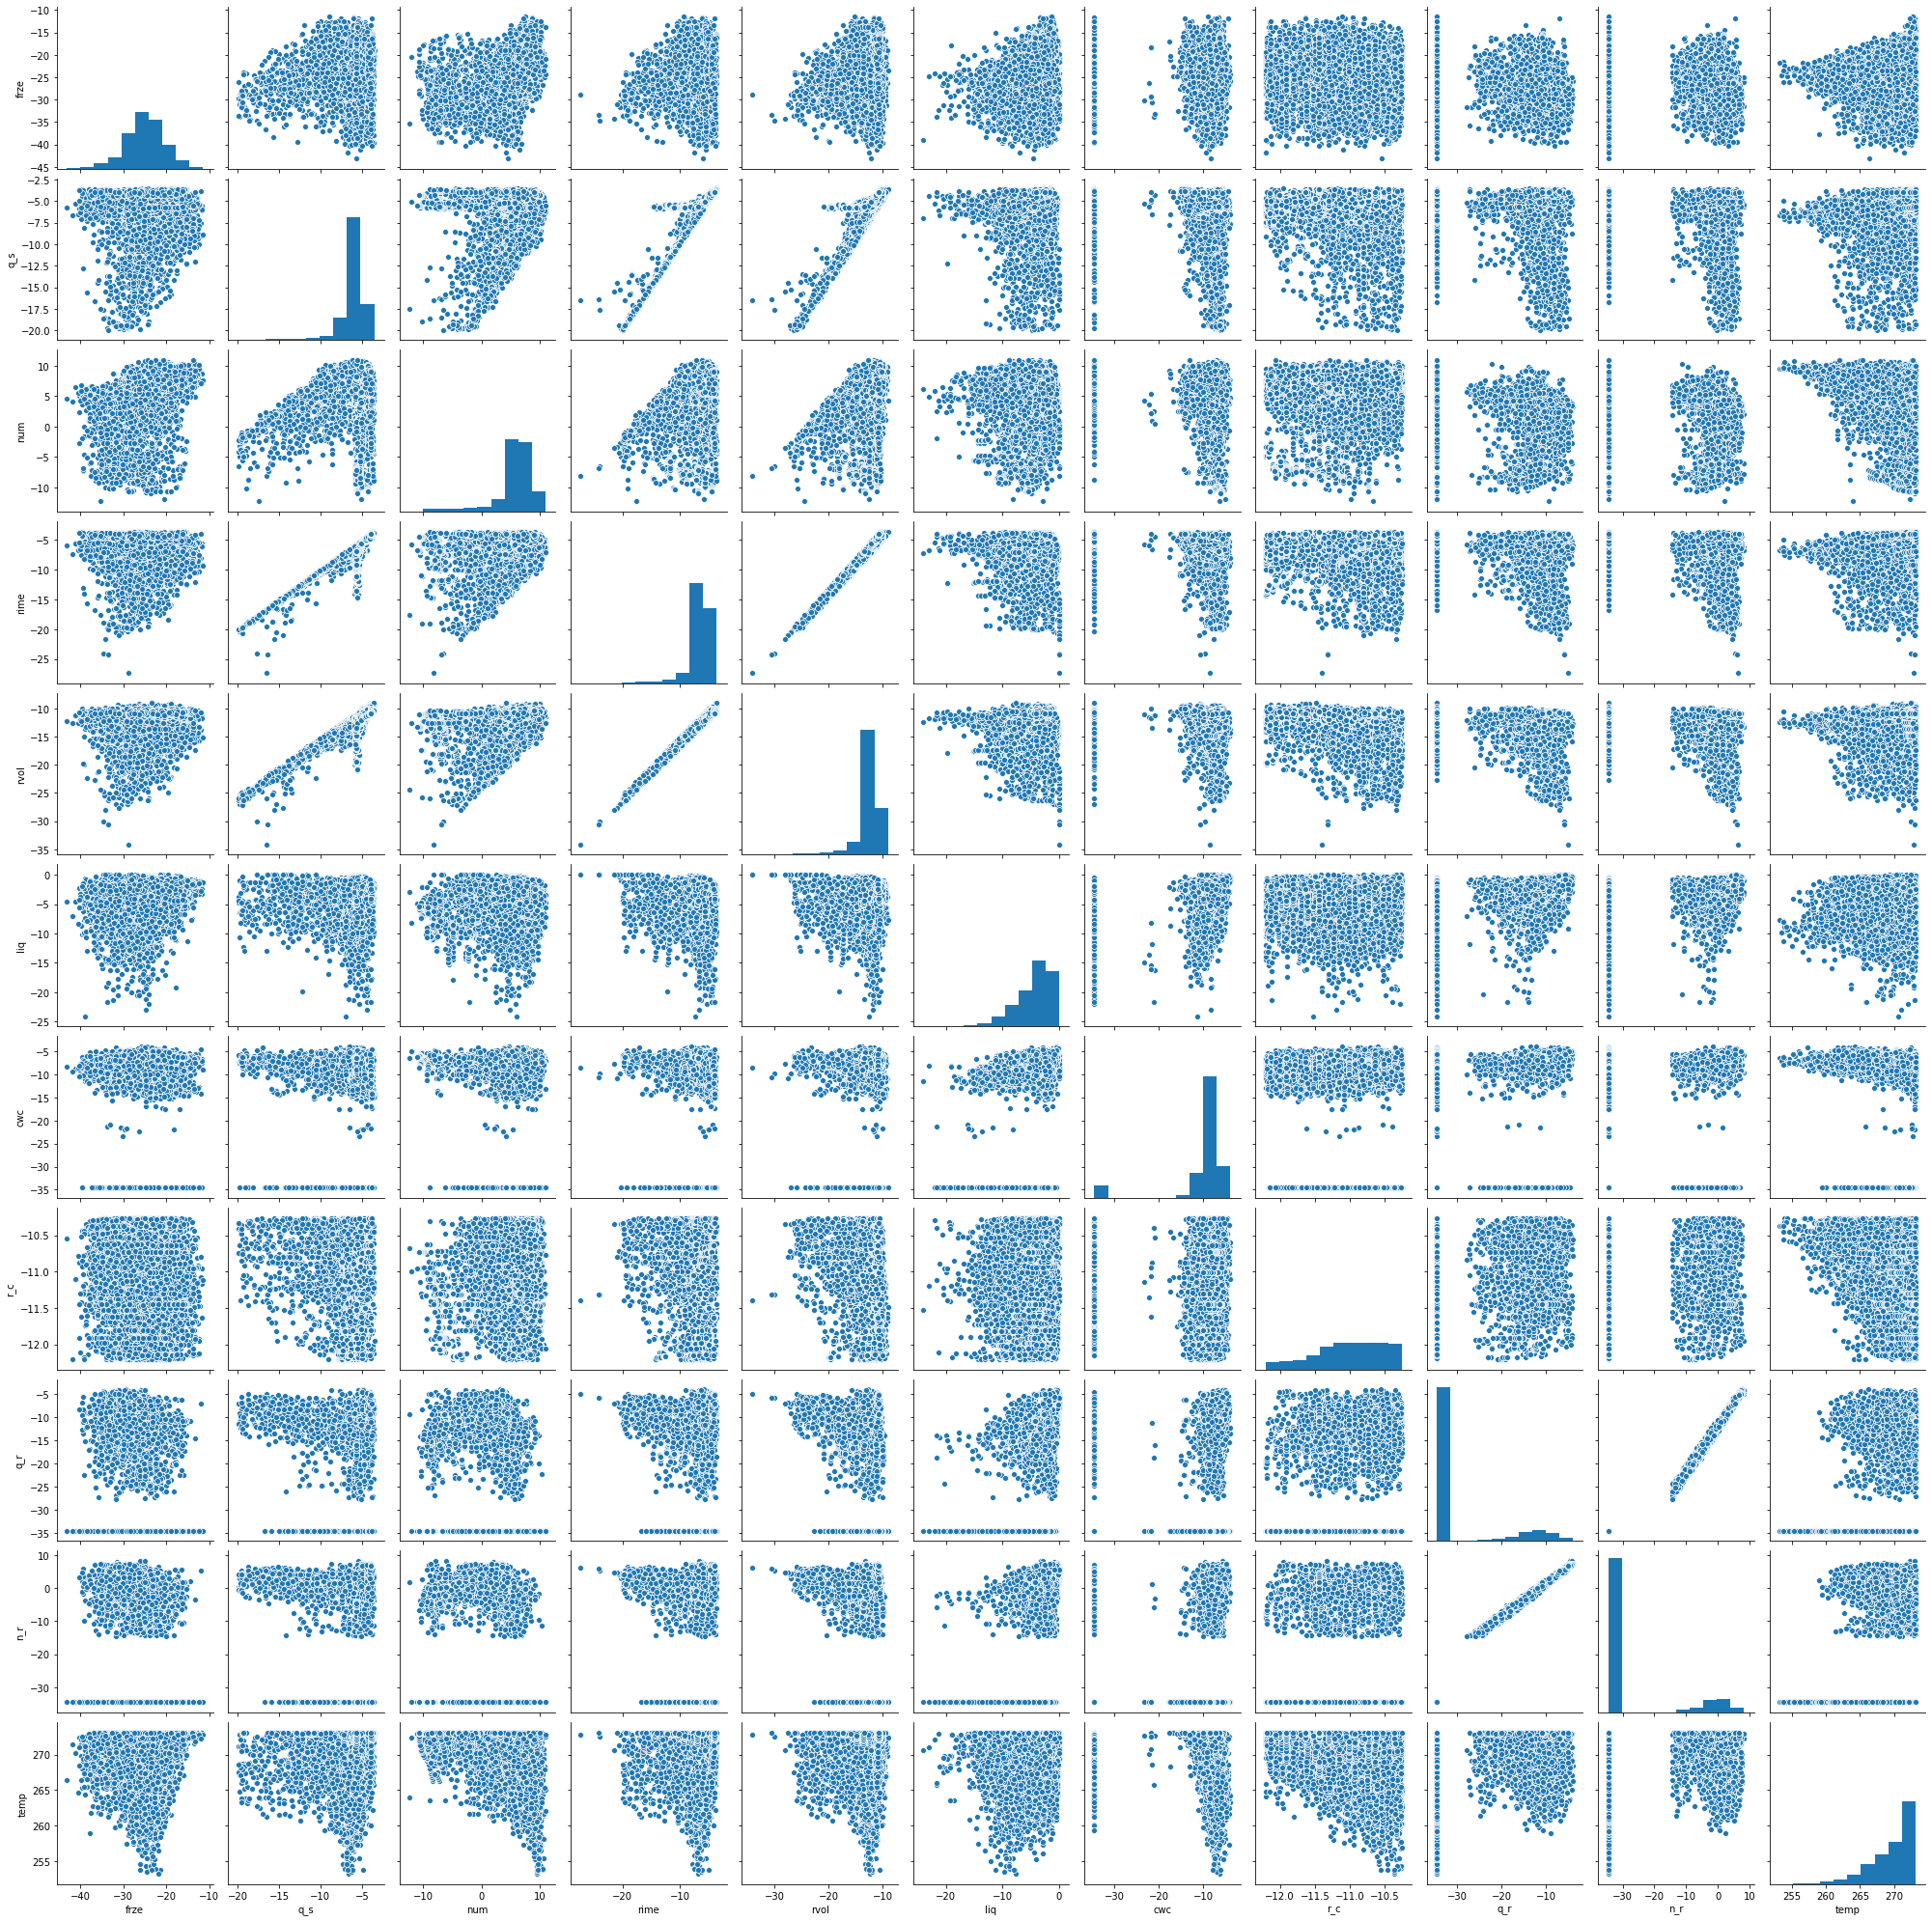

In [18]:
sns.pairplot(dataset_train[["frze","q_s","num","rime","rvol","liq","cwc","r_c","q_r","n_r","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
train_dataset3 = train_dataset3.drop(['temp'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
test_dataset3 = test_dataset3.drop(['temp'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
val_dataset3 = val_dataset3.drop(['temp'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("frze")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean        std        min        25%        50%  \
q_s   13292.0  -6.225845   1.876215 -19.929722  -6.526432  -5.862203   
num   13292.0   5.490140   3.491256 -12.311334   4.730994   6.118244   
rime  13292.0  -6.665912   2.007279 -27.317013  -7.001379  -6.284315   
rvol  13292.0 -12.671390   2.036223 -34.140301 -13.047592 -12.244631   
liq   13292.0  -4.528816   3.034836 -24.034239  -6.192391  -3.683367   
cwc   13292.0 -10.003426   6.519567 -34.538776  -9.579956  -8.355925   
r_c   13292.0 -11.016456   0.483601 -12.203955 -11.346030 -10.961025   
q_r   13292.0 -30.153397   8.951226 -34.538776 -34.538776 -34.538776   
n_r   13292.0 -27.776016  13.588833 -34.538776 -34.538776 -34.538776   

            75%        max  
q_s   -5.331490  -3.518060  
num    7.584703  10.957782  
rime  -5.629153  -3.621830  
rvol -11.596873  -9.060705  
liq   -2.246378  -0.000020  
cwc   -7.280269  -3.812178  
r_c  -10.617928 -10.260426  
q_r  -34.538776  -3.977586  
n_r  -34.538776   8.246982

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("frze")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean        std        min        25%        50%  \
q_s   13292.0  -6.225845   1.876215 -19.929722  -6.526432  -5.862203   
num   13292.0   5.490140   3.491256 -12.311334   4.730994   6.118244   
rime  13292.0  -6.665912   2.007279 -27.317013  -7.001379  -6.284315   
rvol  13292.0 -12.671390   2.036223 -34.140301 -13.047592 -12.244631   
liq   13292.0  -4.528816   3.034836 -24.034239  -6.192391  -3.683367   
cwc   13292.0 -10.003426   6.519567 -34.538776  -9.579956  -8.355925   
r_c   13292.0 -11.016456   0.483601 -12.203955 -11.346030 -10.961025   
q_r   13292.0 -30.153397   8.951226 -34.538776 -34.538776 -34.538776   
n_r   13292.0 -27.776016  13.588833 -34.538776 -34.538776 -34.538776   

            75%        max  
q_s   -5.331490  -3.518060  
num    7.584703  10.957782  
rime  -5.629153  -3.621830  
rvol -11.596873  -9.060705  
liq   -2.246378  -0.000020  
cwc   -7.280269  -3.812178  
r_c  -10.617928 -10.260426  
q_r  -34.538776  -3.977586  
n_r  -34.538776   8.246982

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['frze']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

frze
count  13292.000000
mean     -24.962763
std        4.383825
min      -43.065170
25%      -27.654464
50%      -24.891810
75%      -22.123135
max      -11.492785

In [30]:
train_dataset1.describe()

q_s           num          rime          rvol           liq  \
count  13292.000000  13292.000000  13292.000000  13292.000000  13292.000000   
mean      -6.225845      5.490140     -6.665912    -12.671390     -4.528816   
std        1.876215      3.491256      2.007279      2.036223      3.034836   
min      -19.929722    -12.311334    -27.317013    -34.140301    -24.034239   
25%       -6.526432      4.730994     -7.001379    -13.047592     -6.192391   
50%       -5.862203      6.118244     -6.284315    -12.244631     -3.683367   
75%       -5.331490      7.584703     -5.629153    -11.596873     -2.246378   
max       -3.518060     10.957782     -3.621830     -9.060705     -0.000020   

                cwc           r_c           q_r           n_r  
count  13292.000000  13292.000000  13292.000000  13292.000000  
mean     -10.003426    -11.016456    -30.153397    -27.776016  
std        6.519567      0.483601      8.951226     13.588833  
min      -34.538776    -12.203955    -34.538776    -34.538776  
25%       -9.579956    -11.346030    -34.538776    -34.538776  
50%       -8.355925    -10.961025    -34.538776    -34.538776  
75%       -7.280269    -10.617928    -34.538776    -34.538776  
max       -3.812178    -10.260426     -3.977586      8.246982

In [31]:
train_dataset2.describe()

q_s           num          rime          rvol           liq  \
count  13292.000000  13292.000000  13292.000000  13292.000000  13292.000000   
mean      -6.225845      5.490140     -6.665912    -12.671390     -4.528816   
std        1.876215      3.491256      2.007279      2.036223      3.034836   
min      -19.929722    -12.311334    -27.317013    -34.140301    -24.034239   
25%       -6.526432      4.730994     -7.001379    -13.047592     -6.192391   
50%       -5.862203      6.118244     -6.284315    -12.244631     -3.683367   
75%       -5.331490      7.584703     -5.629153    -11.596873     -2.246378   
max       -3.518060     10.957782     -3.621830     -9.060705     -0.000020   

                cwc           r_c           q_r           n_r  
count  13292.000000  13292.000000  13292.000000  13292.000000  
mean     -10.003426    -11.016456    -30.153397    -27.776016  
std        6.519567      0.483601      8.951226     13.588833  
min      -34.538776    -12.203955    -34.538776    -34.538776  
25%       -9.579956    -11.346030    -34.538776    -34.538776  
50%       -8.355925    -10.961025    -34.538776    -34.538776  
75%       -7.280269    -10.617928    -34.538776    -34.538776  
max       -3.812178    -10.260426     -3.977586      8.246982

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std        min       25%       50%  \
q_s   13292.0  1.624470e-06  1.000002  -7.304001 -0.160210  0.193817   
num   13292.0 -1.054525e-07  1.000001  -5.098873 -0.217442  0.179908   
rime  13292.0  7.504048e-06  0.999999 -10.288106 -0.167125  0.190107   
rvol  13292.0 -3.500678e-06  1.000000 -10.543495 -0.184755  0.209583   
liq   13292.0  2.072962e-07  1.000000  -6.427176 -0.548160  0.278581   
cwc   13292.0  5.066163e-08  0.999999  -3.763341  0.064954  0.252701   
r_c   13292.0 -5.016122e-06  1.000003  -2.455537 -0.681502  0.114620   
q_r   13292.0 -4.355863e-04  0.999980  -0.489919 -0.489919 -0.489919   
n_r   13292.0 -2.763393e-04  0.999976  -0.497670 -0.497670 -0.497670   

           75%       max  
q_s   0.476680  1.443216  
num   0.599945  1.566096  
rime  0.516500  1.516521  
rvol  0.527701  1.773226  
liq   0.752080  1.492270  
cwc   0.417690  0.949641  
r_c   0.824085  1.563336  
q_r  -0.489919  2.924271  
n_r  -0.497670  2.650927

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std        min       25%       50%  \
q_s   13292.0  1.624470e-06  1.000002  -7.304001 -0.160210  0.193817   
num   13292.0 -1.054525e-07  1.000001  -5.098873 -0.217442  0.179908   
rime  13292.0  7.504048e-06  0.999999 -10.288106 -0.167125  0.190107   
rvol  13292.0 -3.500678e-06  1.000000 -10.543495 -0.184755  0.209583   
liq   13292.0  2.072962e-07  1.000000  -6.427176 -0.548160  0.278581   
cwc   13292.0  5.066163e-08  0.999999  -3.763341  0.064954  0.252701   
r_c   13292.0 -5.016122e-06  1.000003  -2.455537 -0.681502  0.114620   
q_r   13292.0 -4.355863e-04  0.999980  -0.489919 -0.489919 -0.489919   
n_r   13292.0 -2.763393e-04  0.999976  -0.497670 -0.497670 -0.497670   

           75%       max  
q_s   0.476680  1.443216  
num   0.599945  1.566096  
rime  0.516500  1.516521  
rvol  0.527701  1.773226  
liq   0.752080  1.492270  
cwc   0.417690  0.949641  
r_c   0.824085  1.563336  
q_r  -0.489919  2.924271  
n_r  -0.497670  2.650927

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std       min        25%       50%        75%  \
frze  13292.0 -24.962763  4.383825 -43.06517 -27.654464 -24.89181 -22.123135   

            max  
frze -11.492785

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(9,32,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.008381 ],
       [-1.0085204],
       [-1.0107949],
       [-1.0130138],
       [-1.0084182],
       [-1.0092919],
       [-1.0109386],
       [-1.0107645],
       [-1.0080839],
       [-1.0105882]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.9407,  mae:0.7528,  mse:0.9407,  val_loss:0.8109,  val_mae:0.6885,  val_mse:0.8109,  
....................................................................................................
Epoch: 100, loss:0.5201,  mae:0.5412,  mse:0.5201,  val_loss:0.5231,  val_mae:0.5359,  val_mse:0.5231,  
......

Text(0, 0.5, 'MAE')

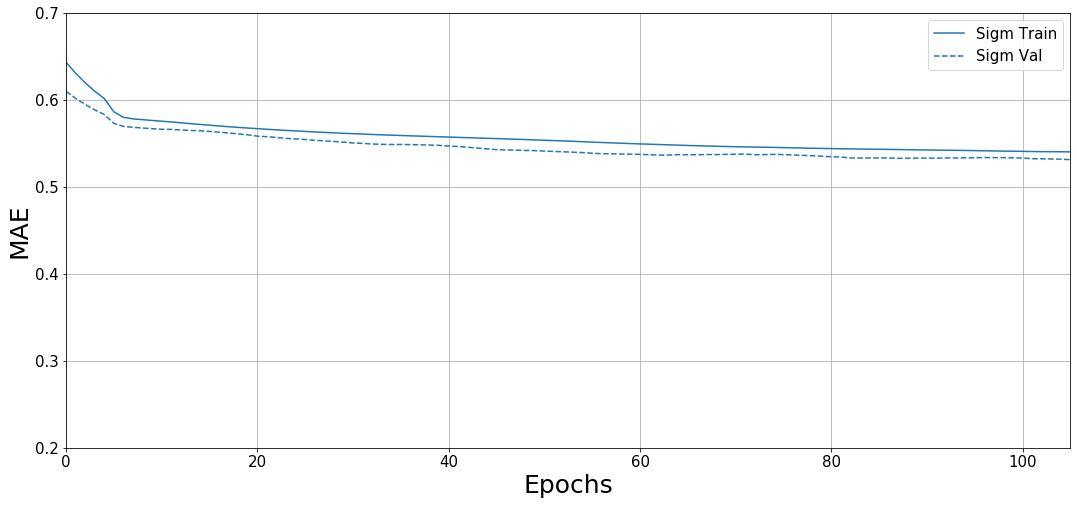

In [43]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.2, 0.7])
plt.ylabel('MAE')

In [44]:
activ = "ReLU"
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7058,  mae:0.6361,  mse:0.7058,  val_loss:0.6103,  val_mae:0.5808,  val_mse:0.6103,  
.................................................................................................

In [45]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.3, 0.7])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [46]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7361,  mae:0.6545,  mse:0.7361,  val_loss:0.5893,  val_mae:0.5733,  val_mse:0.5893,  
....................................................................................................
Epoch: 100, loss:0.4602,  mae:0.5072,  mse:0.4602,  val_loss:0.4856,  val_mae:0.5155,  val_mse:0.4856,  
.

Text(0, 0.5, 'MAE')

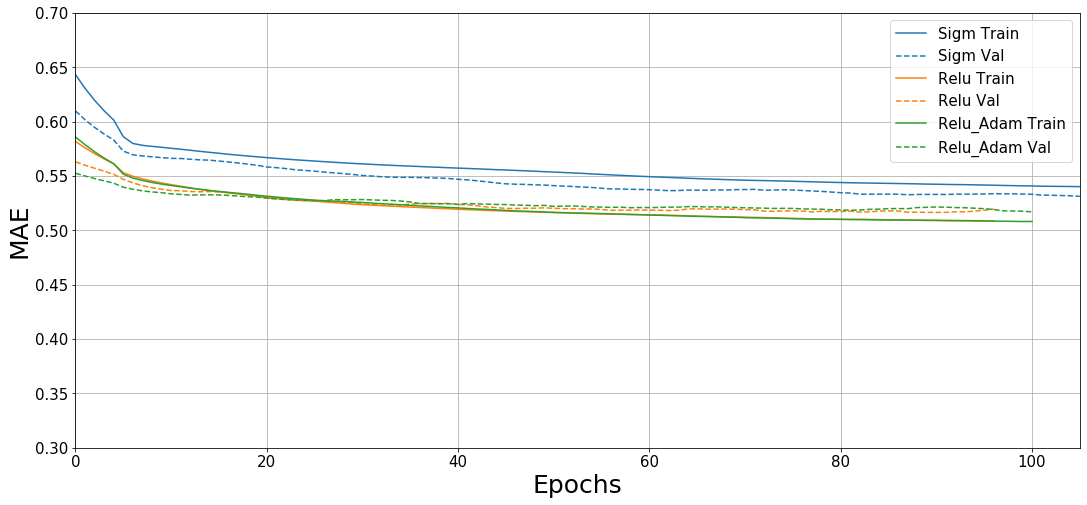

In [47]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.3, 0.7])
plt.ylabel('MAE')

In [48]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.6371,  mae:0.6063,  mse:0.6371,  val_loss:0.5576,  val_mae:0.5570,  val_mse:0.5576,  
.................................................................................................

In [49]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.3, 0.7])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

Text(0, 0.5, 'MSE')

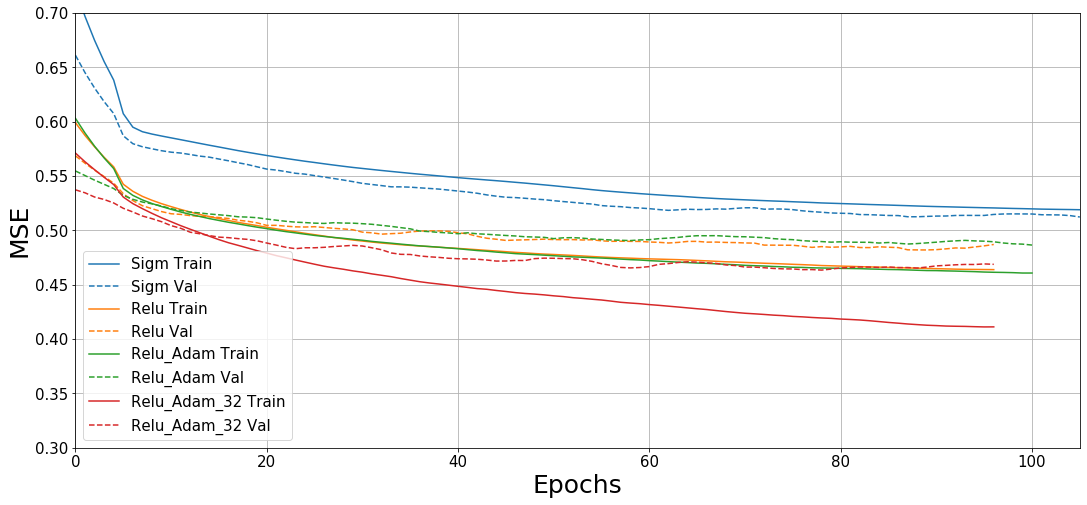

In [50]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.3, 0.7])
plt.ylabel('MSE')

In [51]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

2891/2891 - 0s - loss: 0.5209 - mae: 0.5456 - mse: 0.5209
Testing set for model 1, Mean Abs Error:    0.54561


In [52]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

2891/2891 - 0s - loss: 0.4864 - mae: 0.5217 - mse: 0.4864
Testing set for model 2, Mean Abs Error:              0.52172


In [53]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

2891/2891 - 0s - loss: 0.4833 - mae: 0.5187 - mse: 0.4833
Testing set for model 3, Mean Abs Error:              0.51871


In [54]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

2891/2891 - 0s - loss: 0.4694 - mae: 0.5107 - mse: 0.4694
Testing set for model 4, Mean Abs Error:              0.51067


In [55]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.54560935, 0.52172166, 0.51871324, 0.51067495]

In [56]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.5208786, 0.486351, 0.4833009, 0.4693735]

In [57]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n sigm',
 'model 2: \n ReLU',
 'model 3: \n ReLU_Adam',
 'model 4: \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [58]:
test_true_liq  = np.exp(test_labels.pop('frze'))

In [59]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [60]:
labels = [ "frze" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [61]:
p1.describe()

frze
count  2891.000000
mean      0.021535
std       0.684657
min      -1.953514
25%      -0.494001
50%      -0.018009
75%       0.514185
max       2.021851

In [62]:
train_labels_stats

count       mean       std       min        25%       50%        75%  \
frze  13292.0 -24.962763  4.383825 -43.06517 -27.654464 -24.89181 -22.123135   

            max  
frze -11.492785

In [63]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [64]:
test_predict1.describe()

frze
count  2.891000e+03
mean   6.442830e-10
std    3.566774e-09
min    2.751520e-15
25%    1.653088e-12
50%    1.332057e-11
75%    1.373255e-10
max    1.018952e-07

In [65]:
np.exp(test_dataset1.head())

q_s          num      rime      rvol       liq       cwc       r_c  \
1194  0.002259  3741.270264  0.001827  0.000006  0.000547  0.000148  0.000014   
1202  0.002684  3469.801270  0.002243  0.000007  0.003714  0.000036  0.000014   
1204  0.002710  3437.408936  0.002273  0.000007  0.002184  0.000010  0.000014   
1443  0.000688  2203.319824  0.000341  0.000002  0.000068  0.000216  0.000015   
2191  0.001874  4122.971191  0.001414  0.000005  0.000013  0.000179  0.000016   

               q_r           n_r  
1194  1.000000e-15  1.000000e-15  
1202  1.000000e-15  1.000000e-15  
1204  1.000000e-15  1.000000e-15  
1443  1.000000e-15  1.000000e-15  
2191  1.000000e-15  1.000000e-15

In [66]:
test_predict1.head()

frze
0  4.796299e-11
1  1.406262e-10
2  1.243403e-10
3  1.676104e-11
4  1.442243e-11

In [67]:
test_dataset2.head()

q_s       num      rime       rvol        liq        cwc  \
1194 -6.092815  8.227180 -6.305025 -11.978427  -7.510612  -8.818298   
1202 -5.920596  8.151853 -6.099856 -11.915148  -5.595738 -10.243165   
1204 -5.910924  8.142473 -6.086549 -11.911155  -6.126415 -11.473704   
1443 -7.281816  7.697721 -7.984080 -13.323611  -9.602169  -8.440232   
2191 -6.279605  8.324329 -6.561368 -12.148432 -11.223238  -8.628125   

            r_c        q_r        n_r  
1194 -11.211430 -34.538776 -34.538776  
1202 -11.211430 -34.538776 -34.538776  
1204 -11.211430 -34.538776 -34.538776  
1443 -11.138167 -34.538776 -34.538776  
2191 -11.024560 -34.538776 -34.538776

In [68]:
test_predict1_liq   = test_predict1['frze']

In [69]:
p4 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_liq   = test_predict4['frze']

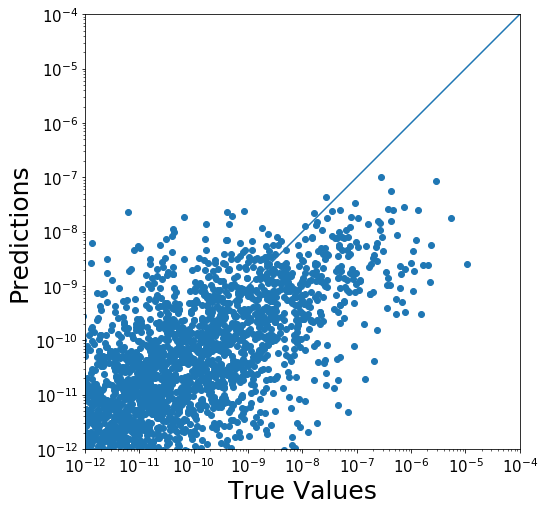

In [70]:
amin, amax = 1e-12, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict1_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

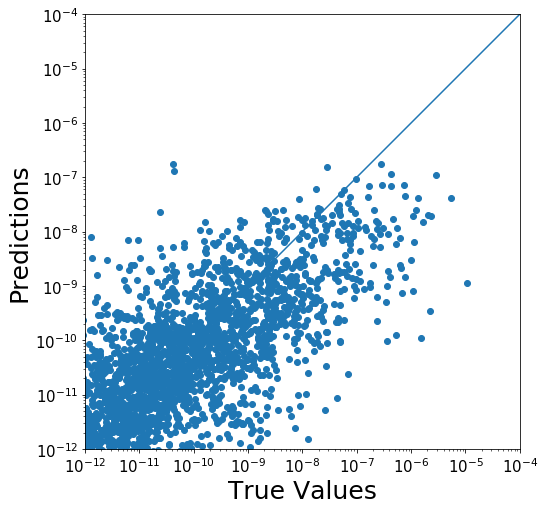

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict4_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [72]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'14'

In [73]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [74]:
train_stats1

count       mean        std        min        25%        50%  \
q_s   13292.0  -6.225845   1.876215 -19.929722  -6.526432  -5.862203   
num   13292.0   5.490140   3.491256 -12.311334   4.730994   6.118244   
rime  13292.0  -6.665912   2.007279 -27.317013  -7.001379  -6.284315   
rvol  13292.0 -12.671390   2.036223 -34.140301 -13.047592 -12.244631   
liq   13292.0  -4.528816   3.034836 -24.034239  -6.192391  -3.683367   
cwc   13292.0 -10.003426   6.519567 -34.538776  -9.579956  -8.355925   
r_c   13292.0 -11.016456   0.483601 -12.203955 -11.346030 -10.961025   
q_r   13292.0 -30.153397   8.951226 -34.538776 -34.538776 -34.538776   
n_r   13292.0 -27.776016  13.588833 -34.538776 -34.538776 -34.538776   

            75%        max  
q_s   -5.331490  -3.518060  
num    7.584703  10.957782  
rime  -5.629153  -3.621830  
rvol -11.596873  -9.060705  
liq   -2.246378  -0.000020  
cwc   -7.280269  -3.812178  
r_c  -10.617928 -10.260426  
q_r  -34.538776  -3.977586  
n_r  -34.538776   8.246982

In [75]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction, cwc, r_c, q_r, n_r'
labels   = 'frze_liq'
logtransform = np.array([True, True, True, True, True, True, True, True, True], dtype=bool)

filename = 'saved_model_v2/frze_rimedsnow_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/frze_rimedsnow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/frze_rimedsnow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/frze_rimedsnow_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/frze_rimedsnow_model1_14.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction, cwc, r_c, q_r, n_r
  Labels:     frze_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/frze_rimedsnow_model2_14.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liq_fraction, cwc, r_c, q_r, n_r
  Labels:     frze_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1